# Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install protobuf==3.20


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.10 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 3.20.0 which is incompatible.
google-api-core 2.19.2 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0.dev0,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
google-cloud-aiplatform 1.73.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 3.20.0 which is incompatible.
google-cloud-bigquery-connection 1.16.1 requir

In [ ]:
!pip install tensorflow==2.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 19.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: goo

In [2]:
import os
import cv2
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    LearningRateScheduler
)
from sklearn.model_selection import train_test_split
import sklearn.metrics

In [3]:
from tensorflow.keras.applications import NASNetMobile

# Data Gathering

In [4]:
# Path ke folder dataset
input_dir = "/content/drive/MyDrive/New_Model/FIXED_DATASET"

# Membaca nama folder yang ada
columns = [folder for folder in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, folder))]

# Buat daftar untuk menyimpan semua file dan kategori biner
merged_unique = []
allColumn_lists = []

# Loop melalui setiap kategori
for category in columns:
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        # Ambil semua file .jpg dalam kategori ini
        category_files = [f for f in os.listdir(category_path) if f.endswith('.jpg') and os.path.isfile(os.path.join(category_path, f))]

        if category_files:  # Hanya tambahkan jika ada file
            # Tambahkan file ke merged_unique
            merged_unique.extend(category_files)
            # Tambahkan daftar file kategori ke allColumn_lists
            allColumn_lists.append(category_files)
        else:
            print(f"Warning: Folder '{category}' kosong atau tidak memiliki file .jpg.")
            allColumn_lists.append([])  # Tambahkan daftar kosong jika folder kosong
    else:
        print(f"Error: Folder '{category}' tidak ditemukan di '{input_dir}'.")
        allColumn_lists.append([])  # Tambahkan daftar kosong jika folder tidak ditemukan

# Hilangkan duplikasi di merged_unique
merged_unique = list(set(merged_unique))

# Buat kolom biner untuk setiap kategori
all_bin_columns = []
for column in allColumn_lists:
    bin_column = []
    for merged_file in merged_unique:
        if merged_file in column:
            bin_column.append(1)  # Cocok
        else:
            bin_column.append(0)  # Tidak cocok
    all_bin_columns.append(bin_column)

# Cek apakah jumlah kategori cocok
if len(columns) != len(all_bin_columns):
    print("Error: Jumlah kolom tidak cocok dengan jumlah kategori!")
    print(f"columns: {len(columns)}, all_bin_columns: {len(all_bin_columns)}")
    exit()

# Buat DataFrame untuk memetakan file dan kategori biner
imageMap_train = pd.DataFrame({'Filenames': merged_unique})
for i, category in enumerate(columns):
    imageMap_train[category] = all_bin_columns[i]

# Atur agar semua kolom terlihat saat dicetak
pd.set_option('display.max_columns', None)

# Tampilkan DataFrame hasil
print(imageMap_train.head(10))

                                           Filenames  Gelas Plastik  Kain  \
0  IMG_20240709_005750_jpg.rf.f4cbccf86370b35be1a...              1     0   
1  botolgelas-18-_jpeg.rf.eb88769136565680a73fcf2...              1     0   
2  plastic-bottle-half-full-water-147900545_61_11...              0     0   
3                                             88.jpg              0     0   
4                                 berantakan (4).jpg              0     1   
5                                       00000080.jpg              0     0   
6                                             84.jpg              0     0   
7                                         R_2859.jpg              0     0   
8                     img20221210163253_20_11zon.jpg              0     0   
9                                         R_2272.jpg              0     0   

   Kertas  Kaleng  Garpu  Sendok  Kardus  Botol Plastik  Kotak susu  Bohlam  
0       0       0      0       0       0              0           0       

In [5]:
# Dictionary untuk menyimpan jumlah sampel per kategori
category_counts = defaultdict(int)

# Loop melalui setiap kategori di dalam folder
for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):  # Pastikan itu folder
        # Hitung jumlah file JPG dalam kategori ini
        num_files = len([f for f in os.listdir(category_path) if f.endswith('.jpg') and os.path.isfile(os.path.join(category_path, f))])
        category_counts[category] += num_files

# Hitung total sampel dan jumlah unik
total_samples = sum(category_counts.values())
unique_samples = len(category_counts)

# Cetak hasil
print("Number of Samples:")
print("-------------------------")
for category, count in category_counts.items():
    print(f"{category} = {count}")
print("--------------------------")
print(f"Total number of samples = {total_samples}")
print(f"Total number of Unique samples = {unique_samples}")

Number of Samples:
-------------------------
Gelas Plastik = 264
Kain = 276
Kertas = 210
Kaleng = 121
Garpu = 165
Sendok = 168
Kardus = 155
Botol Plastik = 206
Kotak susu = 219
Bohlam = 198
--------------------------
Total number of samples = 1982
Total number of Unique samples = 10


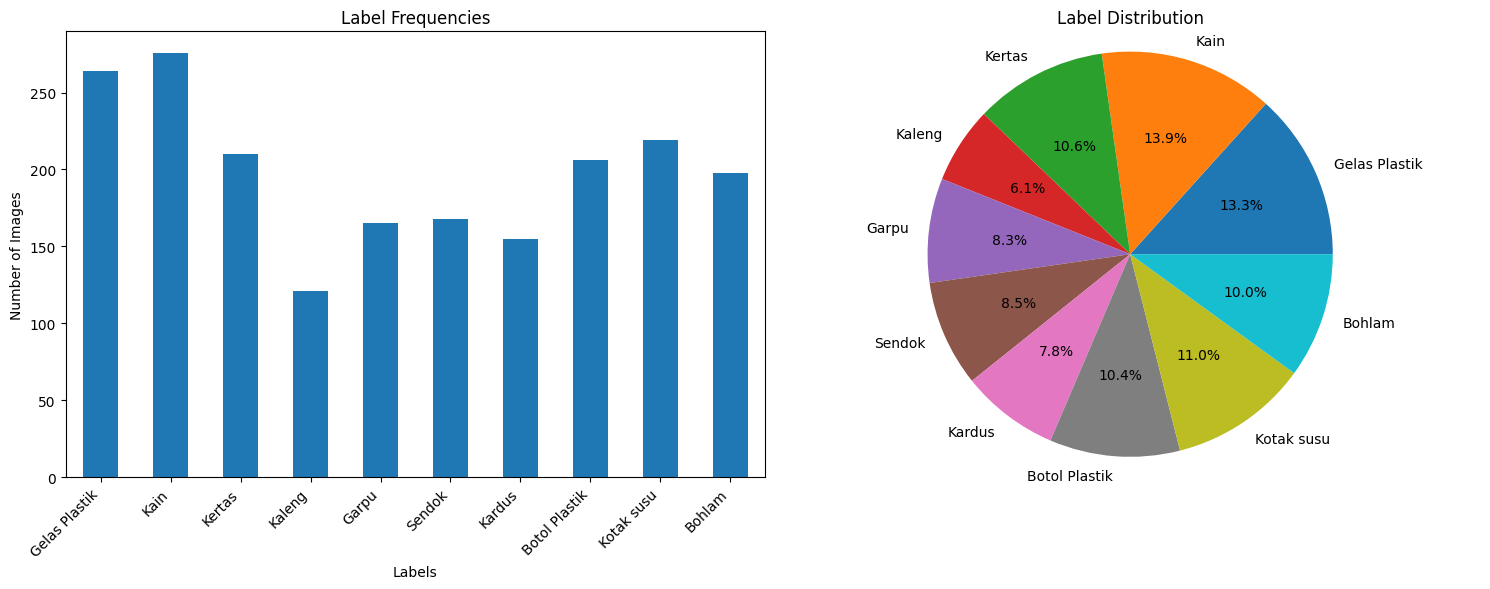

In [6]:
"""Visualize multilabel distribution in the dataset"""

# Get label columns (excluding 'Image_Name')
label_columns = imageMap_train.columns.tolist()[1:]

# Calculate label frequencies
label_frequencies = imageMap_train[label_columns].sum()

# Plotting
plt.figure(figsize=(15, 6))

# Bar plot of label frequencies
plt.subplot(1, 2, 1)
label_frequencies.plot(kind='bar')
plt.title('Label Frequencies')
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Pie chart of label distribution
plt.subplot(1, 2, 2)
plt.pie(label_frequencies, labels=label_frequencies.index, autopct='%1.1f%%')
plt.title('Label Distribution')
plt.axis('equal')
plt.tight_layout()

plt.show()

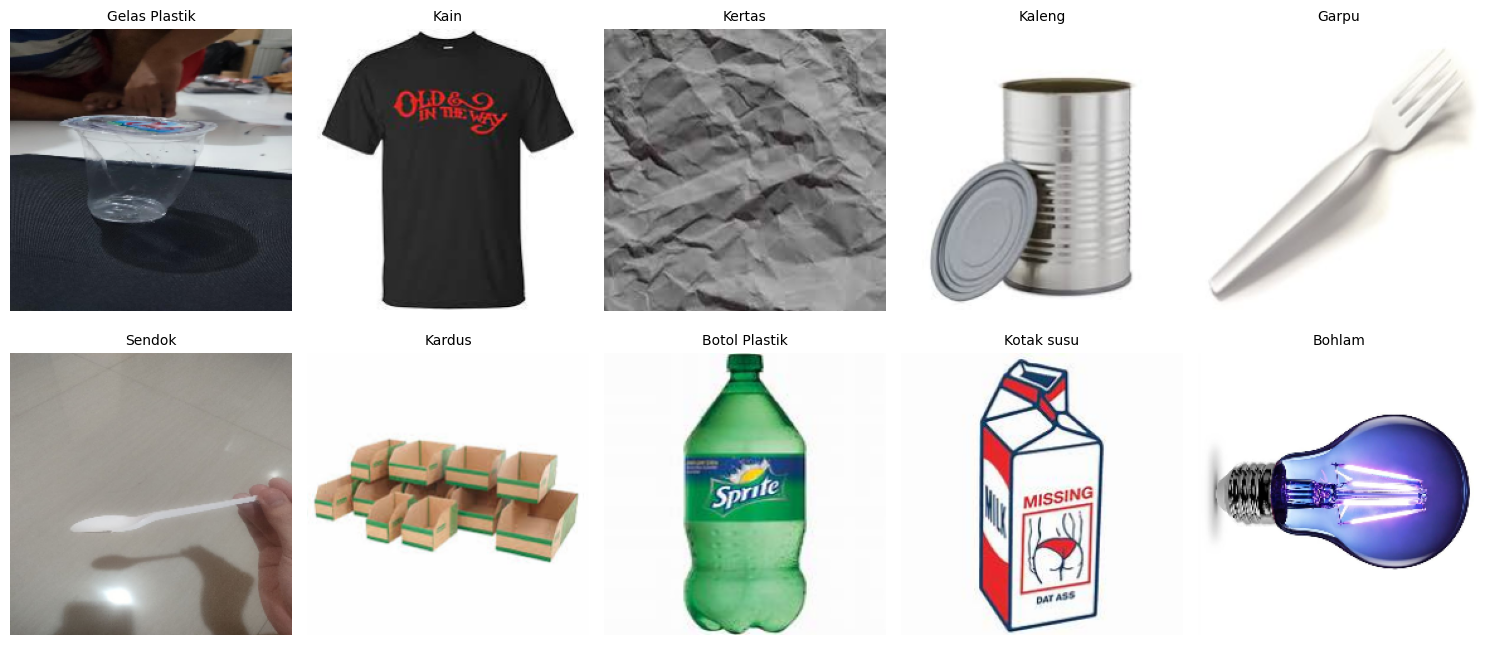


Selected Images:
Category: Gelas Plastik, Filename: IMG_20240709_005614_1_jpg.rf.9126adcf4f58984649727c70a80dfe43.jpg
Category: Kain, Filename: single-piece (20).jpg
Category: Kertas, Filename: paper (112).jpg
Category: Kaleng, Filename: 82.jpg
Category: Garpu, Filename: 00000341.jpg
Category: Sendok, Filename: photo_1_2024-12-12_11-25-47.jpg
Category: Kardus, Filename: R_2195.jpg
Category: Botol Plastik, Filename: 8.jpg
Category: Kotak susu, Filename: 87.jpg
Category: Bohlam, Filename: Ligth_bulb_79_jpg.rf.9be25725c81c2ce4a86f1f931905bf24.jpg


<Figure size 640x480 with 0 Axes>

In [7]:
# Directory of dataset
categories = [folder for folder in os.listdir(input_dir)
                if os.path.isdir(os.path.join(input_dir, folder))]

# Total images to display
total_samples = 10  # Adjust total number of images to display
images_per_class = total_samples // len(categories)

selected_images = []

for category in categories:
    folder_path = os.path.join(input_dir, category)
    # Get all image files in this folder
    all_images = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))]

    # Ensure number of images picked doesn't exceed available images
    if len(all_images) < images_per_class:
        selected_images += random.sample(all_images, len(all_images))  # Take all if not enough
    else:
        selected_images += random.sample(all_images, images_per_class)  # Take requested number

# Create visualization using matplotlib (works in most environments)
def visualize_images(image_paths):
    # Create a new figure with appropriate size
    plt.figure(figsize=(15, 10))

    # Calculate grid dimensions
    rows = 3
    cols = 5

    # Iterate through selected images
    for idx, image_path in enumerate(image_paths):
        # Read image with OpenCV (converts to RGB)
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize image to ensure consistency
        img_resized = cv2.resize(img_rgb, (224, 224))

        # Create subplot
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img_resized)

        # Get category name (last directory name)
        category = os.path.basename(os.path.dirname(image_path))
        plt.title(category, fontsize=10)

        # Remove axis
        plt.axis('off')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Visualize the selected images
visualize_images(selected_images)

# Optional: Save the figure
plt.savefig('dataset_sample_images.png', dpi=300, bbox_inches='tight')

# Bonus: Print out selected image details
print("\nSelected Images:")
for img_path in selected_images:
    print(f"Category: {os.path.basename(os.path.dirname(img_path))}, "
          f"Filename: {os.path.basename(img_path)}")

# Split Data

In [8]:
# Main workflow
output_dataset_dir = "/content/drive/MyDrive/New_Model/Organized_Dataset"
model_output_dir = "/content/drive/MyDrive/New_Model/Waste_Detection_Model"
input_dir="/content/drive/MyDrive/New_Model/FIXED_DATASET"

# Ensure directories exist
os.makedirs(output_dataset_dir, exist_ok=True)
os.makedirs(model_output_dir, exist_ok=True)

In [9]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Directories
input_dir = "/content/drive/MyDrive/New_Model/FIXED_DATASET"

output_dataset_dir = "/content/drive/MyDrive/New_Model/Organized_Dataset"

# Create train, val, and test directories
subsets = ['train', 'val', 'test']
for subset in subsets:
    os.makedirs(os.path.join(output_dataset_dir, subset), exist_ok=True)

# Iterate through categories
for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if not os.path.isdir(category_path):
        continue  # Skip non-directory files

    # List all images in the category
    all_images = [f for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if len(all_images) == 0:
        print(f"No images found in category {category}. Skipping...")
        continue  # Skip categories with no images

    # Split into train, val, test
    train_images, temp_images = train_test_split(all_images, train_size=0.8, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # Move files into corresponding directories
    for subset, images in zip(subsets, [train_images, val_images, test_images]):
        subset_dir = os.path.join(output_dataset_dir, subset, category)
        os.makedirs(subset_dir, exist_ok=True)
        for img in images:
            src = os.path.join(category_path, img)
            dst = os.path.join(subset_dir, img)
            shutil.copy2(src, dst)

print("Dataset reorganized and split successfully!")


Dataset reorganized and split successfully!


# Data Generator

In [10]:
def create_data_generators(train_dir, val_dir, input_shape=(224, 224, 3), batch_size=32):
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest'
    )

    # Simple rescaling for validation
    val_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators
    def multi_hot_generator(datagen, directory, **kwargs):
        # Initial generator
        generator = datagen.flow_from_directory(
            directory,
            target_size=input_shape[:2],
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True,
            **kwargs
        )

        # Modify generator
        for x, y in generator:
            # Convert to multi-hot labels
            y_multi_hot = np.zeros_like(y, dtype=float)
            for i in range(y.shape[0]):
                # Find indices of '1's in the one-hot encoded labels
                label_indices = np.where(y[i] == 1)[0]
                y_multi_hot[i, label_indices] = 1.0

            yield x, y_multi_hot

    # Create custom generators
    train_generator = multi_hot_generator(train_datagen, train_dir)
    val_generator = multi_hot_generator(val_datagen, val_dir)

    # Count number of classes
    initial_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    num_classes = len(initial_generator.class_indices)

    # Print class indices for reference
    print("Class Indices:", initial_generator.class_indices)
    print("Number of Classes:", num_classes)

    return train_generator, val_generator, num_classes

In [11]:
# Prepare data generators
train_dir = os.path.join(output_dataset_dir, '/content/drive/MyDrive/New_Model/Organized_Dataset/train')
val_dir = os.path.join(output_dataset_dir, '/content/drive/MyDrive/New_Model/Organized_Dataset/val')
test_dir = os.path.join(output_dataset_dir, '/content/drive/MyDrive/New_Model/Organized_Dataset/test')

# Create data generators
train_generator, val_generator, num_classes = create_data_generators(
    train_dir,
    val_dir
)

Found 1840 images belonging to 10 classes.
Class Indices: {'Bohlam': 0, 'Botol Plastik': 1, 'Garpu': 2, 'Gelas Plastik': 3, 'Kain': 4, 'Kaleng': 5, 'Kardus': 6, 'Kertas': 7, 'Kotak susu': 8, 'Sendok': 9}
Number of Classes: 10


# Model

In [19]:
def build_model(input_shape=(224, 224, 3), num_classes=10, fine_tune_at=None):
    # Load pre-trained model
    base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze base model layers
    if fine_tune_at:
        # Unfreeze the layers from `fine_tune_at` onwards
        for layer in base_model.layers[fine_tune_at:]:
            layer.trainable = True
    else:
        base_model.trainable = False

    # Add custom layer
    x = base_model.output
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)




    # Output layer with sigmoid activation
    output_layer = Dense(num_classes, activation='softmax', name='waste_classification')(x)

    # Create final model
    model = Model(inputs=base_model.input, outputs=output_layer)

    return model

In [26]:
# Build model
model = build_model(num_classes=10)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Contoh penggunaan dengan model
model.compile(optimizer=Adam(learning_rate=1e-5), loss=loss_fn, metrics=['accuracy'])


In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv1 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn1                  │ (None, 111, 111, 32)   │            128 │ stem_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_190            │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_conv_1_stem_1   │ (None, 111, 111, 11)   │            352 │ activation_190[0][0]   │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_bn_1_stem_1     │ (None, 111, 111, 11)   │             44 │ reduction_conv_1_stem… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_191            │ (None, 111, 111, 11)   │              0 │ reduction_bn_1_stem_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_193            │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 115, 115, 11)   │              0 │ activation_191[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 117, 117, 32)   │              0 │ activation_193[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │            396 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │          1,920 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 11)     │             44 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_r

 Total params: 5,023,583 (19.16 MB)

 Trainable params: 753,867 (2.88 MB)

 Non-trainable params: 4,269,716 (16.29 MB)

In [22]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr  # Keep learning rate same in the first 10 epochs
    else:
        return float(lr * tf.math.exp(-0.1))  # Apply exponential decay


In [23]:
def train_model(model, train_generator, val_generator, train_dir, val_dir, epochs=50):
    # Hitung jumlah sampel di setiap direktori
    def count_samples(directory):
        total_samples = 0
        for root, dirs, files in os.walk(directory):
            # Hitung file gambar (dengan ekstensi umum)
            image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            total_samples += len(image_files)
        return total_samples

    train_samples = count_samples(train_dir)
    val_samples = count_samples(val_dir)

    batch_size = 32  # Sesuaikan dengan batch_size di generator
    steps_per_epoch = max(1, train_samples // batch_size)
    validation_steps = max(1, val_samples // batch_size)

    print(f"Total training samples: {train_samples}")
    print(f"Total validation samples: {val_samples}")
    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")

    # Learning rate reducer
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    # Early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    # Model checkpoint
    model_checkpoint = ModelCheckpoint(
        filepath=os.path.join(model_output_dir, 'best_model.keras'),
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )

    lr_scheduler = LearningRateScheduler(scheduler)
    # Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=[lr_scheduler, reduce_lr, early_stop, model_checkpoint]
    )

    return history

In [24]:
# Fine-tuning function
def fine_tune_model(model, train_generator, val_generator, train_dir, val_dir, fine_tune_at=20, epochs=25):
    model.trainable = True  # Unfreeze the entire model
    def count_samples(directory):
        total_samples = 0
        for root, dirs, files in os.walk(directory):
            # Hitung file gambar (dengan ekstensi umum)
            image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            total_samples += len(image_files)
        return total_samples

    train_samples = count_samples(train_dir)
    val_samples = count_samples(val_dir)

    batch_size = 32  # Sesuaikan dengan batch_size di generator
    steps_per_epoch = max(1, train_samples // batch_size)
    validation_steps = max(1, val_samples // batch_size)
    # Unfreeze the last 'fine_tune_at' layers
    for layer in model.layers[:-fine_tune_at]:
        layer.trainable = False
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    model.compile(optimizer=Adam(learning_rate=1e-5), loss=loss_fn, metrics=['accuracy'])
    # Learning rate reducer
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    # Early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    # Model checkpoint
    model_checkpoint = ModelCheckpoint(
        filepath=os.path.join(model_output_dir, 'best_model.keras'),
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )

    lr_scheduler = LearningRateScheduler(scheduler)
    # Continue training
    history_fine_tune = model.fit(
        train_generator,
        validation_data=val_generator,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=[reduce_lr, early_stop, model_checkpoint]
    )

    return history_fine_tune

In [27]:
# Train model
history = train_model(
    model, train_generator, val_generator, train_dir, val_dir
)

Total training samples: 1840
Total validation samples: 230
Steps per epoch: 57
Validation steps: 7
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.1505 - loss: 2.2792Found 230 images belonging to 10 classes.

Epoch 1: val_loss improved from inf to 2.11265, saving model to /content/drive/MyDrive/New_Model/Waste_Detection_Model/best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.1516 - loss: 2.2785 - val_accuracy: 0.3571 - val_loss: 2.1127 - learning_rate: 1.0000e-05
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.3968 - loss: 2.0791
Epoch 2: val_loss improved from 2.11265 to 1.77318, saving model to /content/drive/MyDrive/New_Model/Waste_Detection_Model/best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 831ms/step - accuracy: 0.3982 - loss: 2.0778 - val_accuracy: 0.6364 - val_loss: 1.7732 - learning_rate: 1.0000e-05
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.6467 - loss: 1.7020
Epoch 3: val_loss improved from 1.7

In [28]:
history_fine_tune = fine_tune_model(model, train_generator, val_generator, train_dir, val_dir, fine_tune_at=20, epochs=20)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.9304 - loss: 0.2566
Epoch 1: val_loss improved from inf to 0.21208, saving model to /content/drive/MyDrive/New_Model/Waste_Detection_Model/best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9304 - loss: 0.2565 - val_accuracy: 0.9242 - val_loss: 0.2121 - learning_rate: 1.0000e-05
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9163 - loss: 0.2738
Epoch 2: val_loss improved from 0.21208 to 0.21186, saving model to /content/drive/MyDrive/New_Model/Waste_Detection_Model/best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 36s 646ms/step - accuracy: 0.9164 - loss: 0.2735 - val_accuracy: 0.9242 - val_loss: 0.2119 - learning_rate: 1.0000e-05
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.9353 - loss: 0.2220
Epoch 3: val_loss improved from 0.21186 to 0.18895, saving model to /content/drive/MyDrive/New_Model/Waste_Detection_Model/best_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 665ms/

# Model Evaluation

In [29]:
input_shape=(224, 224, 3)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Prepare multi-hot labels
y_true = np.zeros((len(test_generator.filenames), len(test_generator.class_indices)))
for i, filename in enumerate(test_generator.filenames):
    # Extract directory name (category) from filepath
    category = os.path.basename(os.path.dirname(filename))
    # Set corresponding index to 1
    y_true[i, test_generator.class_indices[category]] = 1

# Evaluate model
test_loss, test_accuracy = model.evaluate(
    test_generator,
    verbose=1
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
predictions = model.predict(test_generator)

# Apply threshold to predictions
y_pred = (predictions > 0.5).astype(int)

Found 235 images belonging to 10 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9810 - loss: 0.1032
Test Loss: 0.1311
Test Accuracy: 0.9702
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step


In [30]:
# Compute metrics
hamming_loss = sklearn.metrics.hamming_loss(y_true, y_pred)
precision = sklearn.metrics.precision_score(y_true, y_pred, average='samples')
recall = sklearn.metrics.recall_score(y_true, y_pred, average='samples')
f1_score = sklearn.metrics.f1_score(y_true, y_pred, average='samples')

print("\nMetrics:")
print(f"Hamming Loss: {hamming_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Classification Report
class_names = list(test_generator.class_indices.keys())
cr = sklearn.metrics.classification_report(
    y_true,
    y_pred,
    target_names=class_names
)
print("\nClassification Report:")
print(cr)


Metrics:
Hamming Loss: 0.0081
Precision: 0.9404
Recall: 0.9404
F1 Score: 0.9404

Classification Report:
               precision    recall  f1-score   support

       Bohlam       0.95      1.00      0.98        20
Botol Plastik       1.00      0.95      0.98        21
        Garpu       1.00      1.00      1.00        19
Gelas Plastik       1.00      0.93      0.96        27
         Kain       1.00      1.00      1.00        28
       Kaleng       0.96      0.96      0.96        26
       Kardus       0.96      0.85      0.90        26
       Kertas       1.00      0.88      0.94        26
   Kotak susu       0.91      0.91      0.91        23
       Sendok       1.00      0.95      0.97        19

    micro avg       0.98      0.94      0.96       235
    macro avg       0.98      0.94      0.96       235
 weighted avg       0.98      0.94      0.96       235
  samples avg       0.94      0.94      0.94       235



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


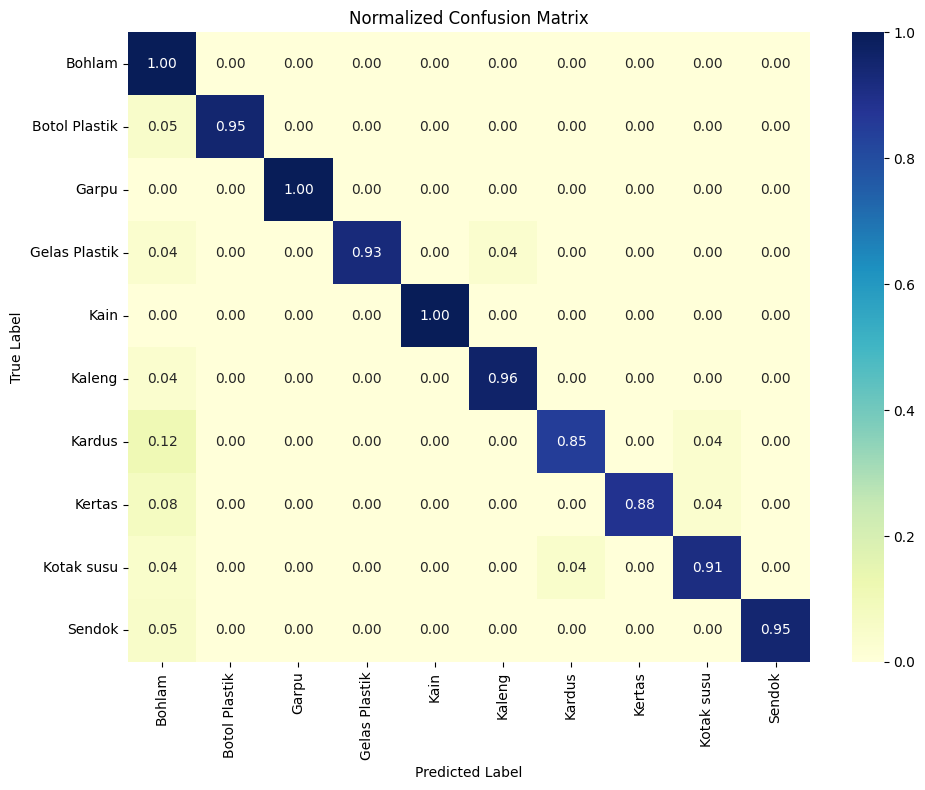

In [31]:
# Confusion Matrix Visualization
plt.figure(figsize=(10, 8))
cm = sklearn.metrics.confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create heatmap using seaborn
sns.heatmap(
    cm_normalized,
    annot=True,  # Show numeric values
    cmap='YlGnBu',  # Color palette
    fmt='.2f',  # Format of the annotations
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

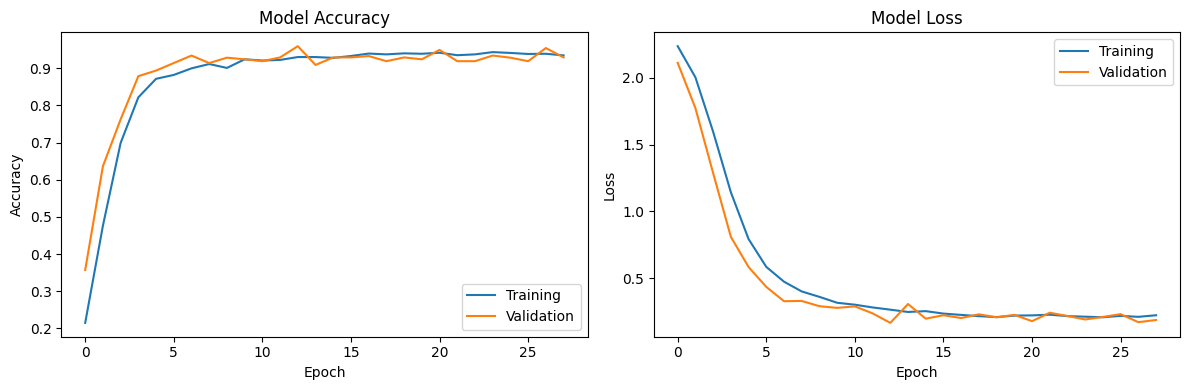

In [32]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
# Save model
model_save_path = os.path.join(model_output_dir, 'waste_detector.h5')
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/New_Model/Waste_Detection_Model/waste_detector.h5


In [34]:
def visualize_model_prediction(image, true_labels, pred_probs, class_names, threshold=0.5):
    # Create figure with more space
    plt.figure(figsize=(15, 6))

    # Display image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Input Image')
    plt.axis('off')

    # Display prediction results
    plt.subplot(1, 2, 2)

    # Prepare prediction labels
    predicted_labels = (pred_probs > threshold).astype(int)

    # Create bar plot of probabilities
    bars = plt.bar(class_names, pred_probs, color='skyblue')
    plt.title('Prediction Probabilities')
    plt.xlabel('Classes')
    plt.ylabel('Probability')
    plt.xticks(rotation=45, ha='right')

    # Add horizontal threshold line
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

    # Color and annotate bars based on prediction
    for i, (prob, pred_label, true_label) in enumerate(zip(pred_probs, predicted_labels, true_labels)):
        # Determine bar color based on prediction accuracy
        if pred_label == true_label:
            color = 'green' if pred_label == 1 else 'lightcoral'
        else:
            color = 'orange'  # Misclassification

        bars[i].set_color(color)

        # Annotate with probability and true/pred status
        status = '✓' if pred_label == true_label else '✗'
        plt.text(i, prob, f'{prob:.2f} {status}',
                 ha='center', va='bottom',
                 color='black', fontweight='bold')

    # Add legend to explain color coding
    plt.legend([
        plt.Rectangle((0,0),1,1, color='green', alpha=0.5),
        plt.Rectangle((0,0),1,1, color='lightcoral', alpha=0.5),
        plt.Rectangle((0,0),1,1, color='orange', alpha=0.5)
    ], [
        'Correct Positive',
        'Correct Negative',
        'Misclassification'
    ], loc='upper right')

    plt.tight_layout()
    plt.show()

In [35]:
# ImageDataGenerator for Testing Data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 235 images belonging to 10 classes.


In [58]:
# Pilih indeks acak dari generator
random_idx = np.random.randint(len(test_generator))

# Ambil batch gambar dan label dari generator
test_batch, test_labels_batch = test_generator[random_idx]

# Choose 1 random image dan labels from batch
image_idx = np.random.randint(len(test_batch))
test_image = test_batch[image_idx]
true_label = test_labels_batch[image_idx]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


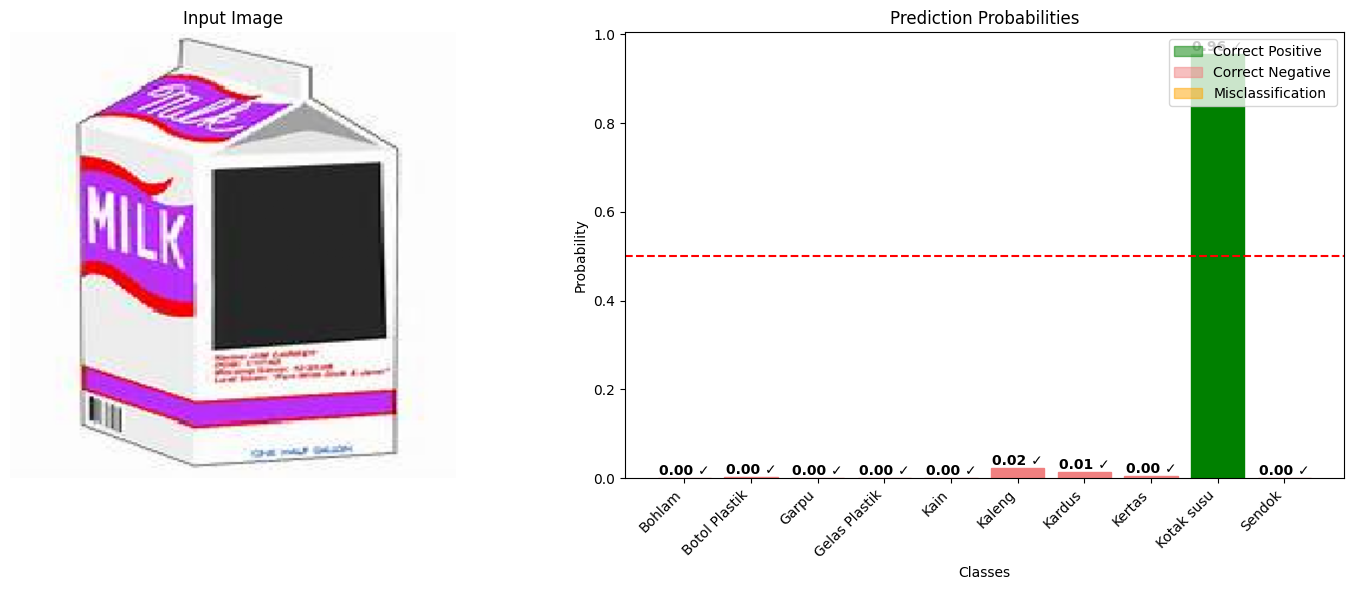

In [59]:
# Predict probabilities
pred_probs = model.predict(np.expand_dims(test_image, axis=0))[0]

# Set Threshold to change Probabilities into Binary label
threshold = 0.5
predicted_labels = (pred_probs > threshold).astype(int)

# Visualize Prediction result
visualize_model_prediction(
    test_image,
    true_label,
    pred_probs,
    list(test_generator.class_indices.keys())
)

# Test Upload Image

In [38]:
from PIL import Image
import numpy as np

# Load the image
test_image_path = "/content/drive/MyDrive/New_Model/WhatsApp Image 2024-12-11 at 08.17.02.jpeg"
image = Image.open(test_image_path)

image_resized = image.resize((224, 224))
image_array = np.array(image_resized) / 255.0  # Normalize pixel values to [0, 1]

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/New_Model/WhatsApp Image 2024-12-11 at 08.17.02.jpeg'

In [ ]:
image_input = np.expand_dims(image_array, axis=0)  # Shape: (1, 224, 224, 3)

# Predict probabilities
pred_probs = model.predict(image_input)[0]

threshold = 0.5
predicted_labels = (pred_probs > threshold).astype(int)

# Display the result
print("Predicted probabilities:", pred_probs)
print("Predicted labels:", predicted_labels)

In [ ]:
# Visualisasikan hasil prediksi
visualize_model_prediction(
    image_resized,
    predicted_labels,
    pred_probs,
    list(test_generator.class_indices.keys())
)